In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.signal import savgol_filter
from scipy.optimize import minimize
import time
from scipy.optimize import least_squares
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import os

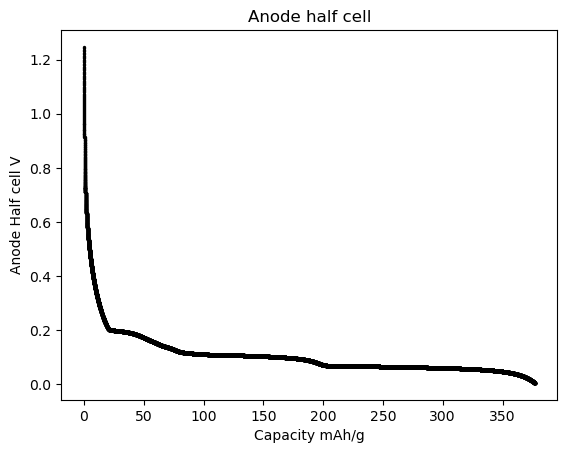

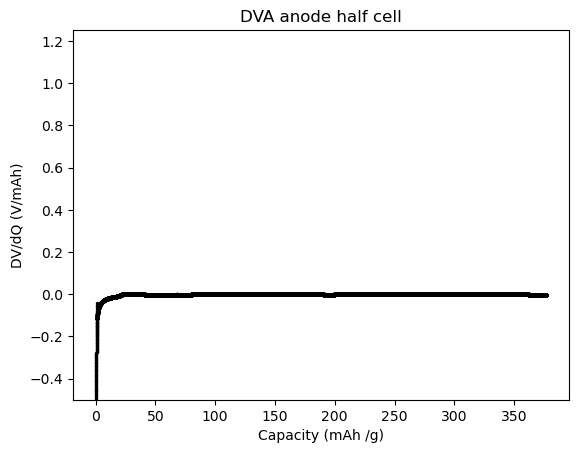

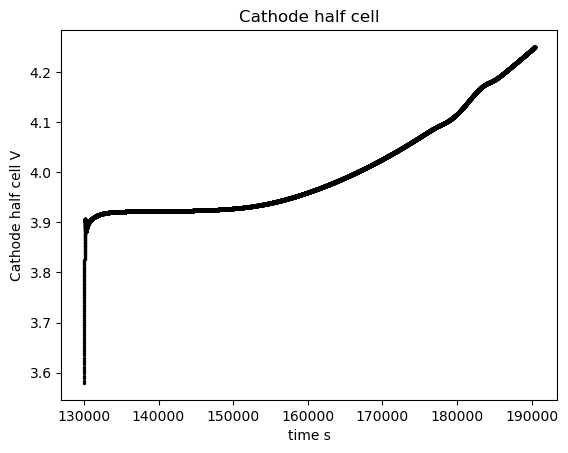

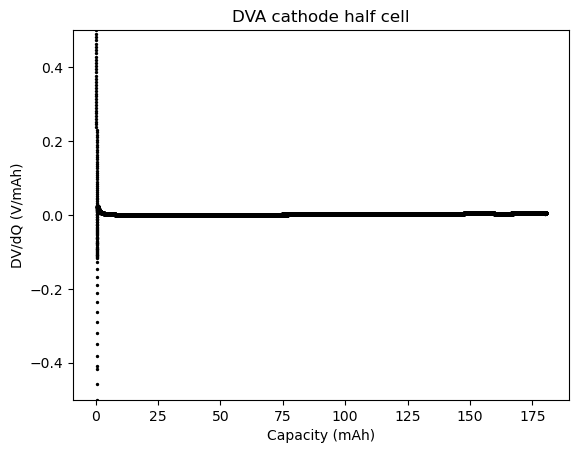

In [2]:
#import information of half-cell potentials
import os
file_path_anode ='C:/Users/r342e598/Desktop/DVA_analysis_V_3/half_cell_data/052924_II_OCV_half_cell_NEGATIVE_manuscript_100DOD/2_052924_II_OCV_half_cell_NEGATIVE_manuscript_100DOD 20240530 191532.CSV'
# Load the dataset into a pandas DataFrame 
anode_df = pd.read_csv(file_path_anode)
file_path_catode ='C:/Users/r342e598/Desktop/DVA_analysis_V_3/half_cell_data/052924_II_OCV_half_cell_POSITIVE_manuscript_100DOD/2_052924_II_OCV_half_cell_POSITIVE_manuscript_100DOD 20240530 190710.csv'
catode_df = pd.read_csv(file_path_catode)


#get the specific capacity- divide capacity by the mass of the 1 square measured when assembling he half cell
# CATHODE Half cell 052924 II: calculated estimation of mass of active material : 0.01858615 g
# ANODE Half cell 052924 II: calculated estimation of mass of active material  : 0.00997152 g


catode_df["Cumulative Charge (mAh/g)"] = catode_df["Cumulative Charge (mAh)"]/  0.01858615
anode_df["Cumulative Charge (mAh/g)"]  = anode_df["Cumulative Charge (mAh)"]/  0.00997152

#plot of anode
anode_df = anode_df[ (anode_df['Repeats'] == 7)].copy()

#reduce noise
anode_df['Working Electrode (V)'] = savgol_filter( anode_df['Working Electrode (V)'] , 400 ,3)

plt.scatter(anode_df["Cumulative Charge (mAh/g)"], anode_df['Working Electrode (V)'], color="black", s=2)
plt.xlabel('Capacity mAh/g') 
plt.ylabel('Anode Half cell V')
plt.title('Anode half cell') 
plt.show()

anode_df['voltage_derivative'] = np.gradient(anode_df['Working Electrode (V)'], anode_df["Cumulative Charge (mAh/g)"])

plt.scatter(anode_df["Cumulative Charge (mAh/g)"], anode_df['voltage_derivative'], color="black", s=2)
plt.xlabel('Capacity (mAh /g)')
plt.ylabel('DV/dQ (V/mAh)')
#plt.xlim(0, 0.0175)
#plt.ylim(0, 0.0252)
#plt.ylim(-0.4, 0.252)
plt.ylim(-0.5, 1.252)
plt.title('DVA anode half cell') 
plt.show()

#cathode
#plot of cathode
#filtrer one cycle of charge of the measured cathode half cell

catode_df = catode_df[ (catode_df['Repeats'] == 5)].copy()
catode_df['Working Electrode (V)'] = savgol_filter( catode_df['Working Electrode (V)'] , 400 ,3)
plt.scatter(catode_df["Elapsed Time (s)"], catode_df['Working Electrode (V)'], color="black", s=2)
plt.xlabel('time s') 
plt.ylabel('Cathode half cell V')
plt.title('Cathode half cell') 
plt.show()

catode_df['voltage_derivative'] = np.gradient(catode_df['Working Electrode (V)'], catode_df["Cumulative Charge (mAh/g)"])
plt.scatter(catode_df["Cumulative Charge (mAh/g)"], catode_df['voltage_derivative'], color="black", s=2)
plt.xlabel('Capacity (mAh)')
plt.ylabel('DV/dQ (V/mAh)')
#plt.xlim(0, 0.0175)
#plt.ylim(0, 0.0252)
plt.ylim(-0.5, 0.5)
plt.title('DVA cathode half cell') 
plt.show()



In [2]:
#This code presents the parameter for the Cell cycled at 100 deph of discharge (DOD) at 25 C
# For different DODs update the initial conditials, and other parameters accordingly (names and bounds for example).

import os
# Define the base directory
base_dir = 'C:/Users/r342e598/Desktop/DVA_analysis_V_3/100percDOD_RT'

# Initialize a list to store capacities for all RPTs,anodes etc...
ml_results = []
rpt_dataframes = []
anode_rpt_data = []

# Store capacity of RPT1 for later percentage calculations
capacity_rpt1 = None

# Initial guess for the first iteration
initial_guess = [0.20, 0.17, -3, -0.08] 
limit_mp=0.21 

#initial_guess = [0.215, 0.18, -0.2, -0.08] # best so far, and do not let udate for  50 DOD
#limit_mp=0.22  # for 50 DOD

#initial_guess = [0.215, 0.18, -0.2, -0.08] # best so far, and do not let udate the values  25 dod
#limit_mp=0.22   # 25 dod



# Iterate through each folder in the base directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    if os.path.isdir(folder_path) and 'RPT_' in folder_name:
        # Extract the RPT number from the folder name
        rpt_number = folder_name.split('_')[2]
        rpt_df_name = f'rpt_{rpt_number}_df'

        # Find the CSV file starting with '2_'
        for file_name in os.listdir(folder_path):
            if file_name.startswith('2_') and file_name.endswith('.csv'):
                file_path_full_cell = os.path.join(folder_path, file_name)

                # Read the CSV file
                rpt_df = pd.read_csv(file_path_full_cell)
                
                # Plotting the data
                plt.scatter(rpt_df['Elapsed Time (s)'], rpt_df['Working Electrode (V)'], s=3, label=f'RPT {rpt_number}')
                plt.xlabel('Time (s)')
                plt.ylabel('Potential (V)')
                plt.title(f'Potential vs. Time Measured Aged Cell RPT {rpt_number}')
                plt.xlim(0, 95000)
                plt.legend()
                plt.show()

               # Internal resistance calculation
                first_potential = rpt_df.loc[rpt_df['Repeats'] == 1, 'Working Electrode (V)'].iloc[-1]
                start_time = rpt_df.loc[rpt_df['Repeats'] == 1 , 'Elapsed Time (s)' ].iloc[-1]
                last_potential = rpt_df.loc[rpt_df['Repeats'] == 3, 'Working Electrode (V)'].iloc[0]
                delta_potential_measured = last_potential - first_potential
                 
                 
                #new line get the x for the first potencial,add these lines to the others DODs 
                first_potential_x = rpt_df.loc[rpt_df['Repeats'] == 1, 'Elapsed Time (s)' ].iloc[-1]
                
                subset = rpt_df[rpt_df['Repeats'] == 3].iloc[:2]
                x1, x2 = subset['Elapsed Time (s)']
                y1, y2 = subset['Working Electrode (V)']
                print(f' x1 {x1}')
                print(f' x2 {x2}')
                print(f' y1 {y1}')
                print(f' y2 {y2}')
                a = (y2 - y1) / (x2 - x1)
                b = y1 - (a * x1)
                
                first_potential_V_linear = (a * first_potential_x ) + b
                print(f'Linear equation: y = {a:f}x + {b:f}')
                print(f'Value of y (first_potential_V_linear) for x = {first_potential_x}: {first_potential_V_linear:f}')

                diference_v=  first_potential -  first_potential_V_linear 
                
                # Isolate the first discharge
                rpt_df = rpt_df[rpt_df['Repeats'] == 3].copy()
                end_time =  rpt_df['Elapsed Time (s)'].iloc[-1]
                mean_current = rpt_df['Current (A)'].mean()
                
                time_difference = end_time - start_time
                cell_internal_resistance = delta_potential_measured / mean_current
                #a different aproach can be used to determine the IR, wich consits in doing a linear fitting in the voltage drop
                linear_aproach_IR= diference_v/ mean_current*(-1)
                capacity = (time_difference/3600) * mean_current
                
                print(f"RPT {rpt_number} - capacity:  {capacity} Ah")
                print(f"RPT {rpt_number} - cell_internal_resistance: {cell_internal_resistance} ohms")
                print(f"RPT {rpt_number} - cell_internal_resistance linear aproach: {linear_aproach_IR} ohms")
                print(f"RPT {rpt_number} - first_potential: {first_potential}")
                print(f"RPT {rpt_number} - last_potential: {last_potential}")
                print(f"RPT {rpt_number} - delta_potential_measured: {delta_potential_measured}")
                print(f"RPT {rpt_number} - mean_current: {mean_current}")
                print(f"first value 'Elapsed Time (s)': {start_time}")
                print(f"last value 'Elapsed Time (s)': {end_time}")
                print(f"time difference s : {time_difference}")
                print(f"time difference in hours : {time_difference/3600}")
                
                 # Set capacity_rpt1 during the first iteration (RPT1)
                if rpt_number == "1":
                    capacity_rpt1 = capacity
                
                # Calculate percentage capacity and determine capacity
                percentage_capacity = (capacity / capacity_rpt1) * 100 
                
 
                # Reverse the order of 'Working Electrode (V)' for voltage derivative calculation
                inverted_vd = rpt_df['Working Electrode (V)'].values[::-1]
                rpt_df['Working Electrode (V)'] = inverted_vd
                rpt_df['voltage_derivative'] = np.gradient(rpt_df['Working Electrode (V)'], rpt_df['Cumulative Charge (mAh)'])
                rpt_df['voltage_derivative'] = savgol_filter(rpt_df['voltage_derivative'], 15, 1)

                # Plotting voltage
                plt.scatter(rpt_df['Elapsed Time (s)'], rpt_df['Working Electrode (V)'], color="blue", s=3)
                plt.xlabel('Time (s)')
                plt.ylabel('Potential (V)')
                plt.title(f'First OCV Discharge Measured Aged Cell RPT {rpt_number} (Inverted)')
                #plt.savefig(f'OCV_RPT_{rpt_number}.png')
                plt.show()

                # Plotting DVA
                plt.scatter(rpt_df['Cumulative Charge (mAh)'], rpt_df['voltage_derivative'], color="red", s=2)
                plt.xlabel('Capacity (mAh)')
                plt.ylabel('DV/dQ (V/mAh)')
                plt.ylim(0, 0.0452)
                plt.title(f'DVA Measured Aged Cell RPT {rpt_number}')
                #plt.savefig(f'dVA_RPT_{rpt_number}.png')
                plt.show()
                
                
                # Solver optimization and plotting
                # Define the range of common_x
                min_capacity = 0
                max_capacity = (capacity*-1000)
                num_points = 1000
                common_x = np.linspace(min_capacity, max_capacity, num_points)
                
                def error_function(params):
                    mp, mn, delta_p, delta_n = params
                    anode_df['anode_der'] = np.gradient(anode_df['Working Electrode (V)'], ((anode_df["Cumulative Charge (mAh/g)"] * mn) + delta_n))
                    catode_df['catode_der'] = np.gradient(catode_df['Working Electrode (V)'], ((catode_df["Cumulative Charge (mAh/g)"] * mp) + delta_p))
                    anode_df['anode_der'] = savgol_filter(anode_df['anode_der'], 50, 1)
                    catode_df['catode_der'] = savgol_filter(catode_df['catode_der'], 50, 1)
                    catode_interp = np.interp(common_x, (catode_df["Cumulative Charge (mAh/g)"] * mp) + delta_p, catode_df['catode_der'])
                    anode_interp = np.interp(common_x, (anode_df["Cumulative Charge (mAh/g)"] * mn) + delta_n, anode_df['anode_der'])
                    subtracted_data = catode_interp - anode_interp
                    interp_full_cell = np.interp(common_x, rpt_df["Cumulative Charge (mAh)"], rpt_df['voltage_derivative'])
                    subtracted_data = savgol_filter(subtracted_data, 50, 1)
                    interp_full_cell = savgol_filter(interp_full_cell, 50, 1)
                    
                    error = np.sum((subtracted_data - interp_full_cell)**2)
                    
                    return error

                bounds = [(0.17, limit_mp), (0.15, 0.165), (-4, 0), (-1, 0)]  #for 100 DOD
                #bounds = [(0.19,  limit_mp), (0.17, 0.18), (-3, 0), (-0.5, 0)]  #for 25 DOD
                #bounds = [(0.19,  limit_mp), (0.17, 0.18), (-3, 0), (-0.5, 0)] # for 50 DOD
                ## Define constraints
                constraints = [
                {'type': 'ineq', 'fun': lambda params: params[0] - params[1]},]  # Ensures mp > mn]
   

                # Define callback function to print progress

                iteration = 0
                def callback(xk, *args, **kwargs):
                    global iteration
                iteration += 1
                #print(f"Iteration {iteration}:")
                #print("Current parameters:", xk)
                #print("Current error:", error_function(xk))
                #print("-" * 30)
                # Record start time
                start_time = time.time()

                # Perform optimization
                result = minimize(error_function, initial_guess, method='trust-constr', bounds=bounds
                            , constraints=constraints
                             , options={'gtol': 1e-6}, callback=callback)

               # Record end time
                end_time = time.time()

               # Extract optimized parameters
                mp_opt, mn_opt, delta_p_opt, delta_n_opt = result.x
                limit_mp = result.x[0]

                print("Optimized parameters:")
                print("mp:", mp_opt)
                print("mn:", mn_opt)
                print("delta_p:", delta_p_opt)
                print("delta_n:", delta_n_opt)
                print("Total optimization time:", end_time - start_time, "seconds")
                print("limit mp:",limit_mp)
                
                # Define the range of common_x
                anode_df['anode_der1'] = np.gradient(anode_df['Working Electrode (V)'], ((anode_df["Cumulative Charge (mAh/g)"] * mn_opt) + delta_n_opt))
                catode_df['catode_der1'] = np.gradient(catode_df['Working Electrode (V)'], ((catode_df["Cumulative Charge (mAh/g)"] * mp_opt) + delta_p_opt))
                catode_interp1 = np.interp(common_x, (catode_df["Cumulative Charge (mAh/g)"] * mp_opt) + delta_p_opt, catode_df['catode_der1'])
                anode_interp1 = np.interp(common_x, ((anode_df["Cumulative Charge (mAh/g)"] * mn_opt) + delta_n_opt), anode_df['anode_der1'])
                subtracted_data1 = catode_interp1 - anode_interp1
                interp_full_cell = np.interp(common_x, rpt_df["Cumulative Charge (mAh)"], rpt_df['voltage_derivative'])
                
                plt.plot(common_x, subtracted_data1, label=f'Model RPT {rpt_number}', color='black')
                plt.plot(common_x, interp_full_cell , label=f'Measured  RPT {rpt_number}', color='red')
                #plt.plot(rpt_df["Cumulative Charge (mAh)"], rpt_df['voltage_derivative'], label='Measured full cell', color='red')
                plt.xlabel('Capacity (mAh)')
                plt.ylabel('DVA')
                plt.title(f'Comparison of DVA Full Cell Estimated and Measured RPT {rpt_number}')
                plt.ylim(0, 0.1)
                #plt.xlim(0, 40)
                plt.legend()
                #plt.savefig(f'First_fitting_dVA_RPT_{rpt_number}.png')
                plt.show()
                
                # Different way to change the fitting parameter: update the initial guess for the next iteration
                #initial_guess = [mp_opt, mn_opt, delta_p_opt, delta_n_opt]
        
                #---------------------------------------------------------------------------------------------------------------
                #-----------------------------------------------------------------------------------------------------------------
                mp1 =   mp_opt
                mn1 =  mn_opt
                delta_p1 = delta_p_opt
                delta_n1 = delta_n_opt
                #-------------------------------------------------------------------------
                #--------------------------------------------------reconstitute the anode
                #initial value

                #add this interpolation, and choose a comoom x 
                catode_df['catode_der1'] =np.gradient(catode_df['Working Electrode (V)'],((catode_df["Cumulative Charge (mAh/g)"] * mp1) + delta_p1))
                common_x2 = np.linspace(((catode_df["Cumulative Charge (mAh/g)"] * mp1) + delta_p1).min(), (rpt_df["Cumulative Charge (mAh)"]).max(),5000)
                catode_interp1= np.interp(common_x2, (catode_df["Cumulative Charge (mAh/g)"] * mp1) + delta_p1, catode_df['catode_der'])
                interp_full_cell = np.interp(common_x2, rpt_df["Cumulative Charge (mAh)"], rpt_df['voltage_derivative'])
                x = common_x2
                y = (catode_interp1 - interp_full_cell)
                
                
                #get anode halfcel from 1st DVA
                # numerical integration using the trapezoidal rule
                initial_value = 0.0
                for i in range(1, len(x)):
                # Trapezoidal rule formula
                    initial_value += abs((x[i] - x[i - 1]) * (y[i] + y[i - 1]) / 2.0)

                print("initial value Numerical integral (Trapezoidal rule):",  initial_value)


                # arrays to store cumulative integral values and x points
                integral_values = np.zeros_like(y, dtype=float)
                integral_values[0] =  initial_value # Initial integral value, it should be 1.6

                # Compute cumulative integral using the trapezoidal rule
                for i in range(1, len(x)):
                # Trapezoidal rule formula
                    integral_values[i] = integral_values[i - 1] + (x[i] - x[i - 1]) * (y[i] + y[i - 1]) / 2.0



                # Plot cumulative integral as a line plot
                plt.plot(x, integral_values, linestyle='--', marker='o', color='r', markersize=3, label='Cumulative Integral')
                plt.plot(anode_df["Cumulative Charge (mAh/g)"]*16*0.00997152, anode_df['Working Electrode (V)'], label='Anode half cell', linestyle='--')
                plt.xlabel('Capacity (mAh)')
                plt.ylabel('Cumulative Integral V')
                plt.title(f'Simulated Anode x measured Anode half cell - RPT {rpt_number}')
                plt.legend()
                plt.grid(True)
                plt.xlim(0, 62)
                plt.ylim(0, 2)
                plt.tight_layout()
                #plt.savefig(f'Simulated_anode__fitting_2dVA_RPT_{rpt_number}.png')
                plt.show()

                # Determine the region of interest based on percentage of x
                total_length = len(x)
                start_index = int(total_length * 0.75)
                end_index = int(total_length * 0.85)

                x_region = x[start_index:end_index]
                y_region = integral_values[start_index:end_index]

                # Define functions for fitting
                def step_function(x, x0, y0, y1):
                    return np.where(x < x0, y0, y1)

                def linear_decay(x, m, b):
                    return m * x + b

                # Fit the step function
                popt_step, _ = curve_fit(step_function, x_region, y_region, p0=[np.mean(x_region), np.min(y_region), np.max(y_region)])

                # Fit the linear decay
                popt_lin, _ = curve_fit(linear_decay, x_region, y_region, p0=[-1, np.max(y_region)])

                # Generate points for plotting the fitted functions
                x_fit = np.linspace(np.min(x_region), np.max(x_region), 300)
                y_fit_step = step_function(x_fit, *popt_step)
                y_fit_lin = linear_decay(x_fit, *popt_lin)

                # Calculate RMSE for both fits
                y_fit_step_region = step_function(x_region, *popt_step)
                y_fit_lin_region = linear_decay(x_region, *popt_lin)

                rmse_step = np.sqrt(mean_squared_error(y_region, y_fit_step_region))
                rmse_lin = np.sqrt(mean_squared_error(y_region, y_fit_lin_region))

                # Determine which model fits better
                if rmse_step < rmse_lin:
                    homogeneity = 'High homogeneity (narrow, well-described by a step function)'
                    homogeneity_desc = 'High'
                else:
                    homogeneity = 'Low homogeneity (broader, better described by a linear decay)'
                    homogeneity_desc = 'Low'

                # Plotting
                plt.plot(x, integral_values, label='Data', color='gray', alpha=0.5)
                plt.scatter(x_region, y_region, color='red', label='Region of Interest (75%-85%)', s=100)  # Increase marker size

                # Plot the fitted functions
                plt.plot(x_fit, y_fit_step, label='Step Function Fit', linestyle='--')
                plt.plot(x_fit, y_fit_lin, label='Linear Decay Fit', linestyle=':')

                plt.xlabel('Capacity (mAh)')
                plt.ylabel('Voltage V')
                plt.title(f'Distribution and Fitting in the Region of Interest \n{homogeneity}')
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1)
                plt.xlim(0, 40)
                plt.show()

                # Print RMSE values and homogeneity result
                print(f"RMSE for Step Function: {rmse_step:.4f}")
                print(f"RMSE for Linear Decay: {rmse_lin:.4f}")
                print(f"Homogeneity: {homogeneity}")

                # Get slope
                slope_rpt, intercept_rpt, _, _, _ = linregress(x_region, y_region)

                print(f'Slope of RPT {rpt_number}  : {slope_rpt}')

                # Plot the data and the fitted lines
                plt.plot(x, integral_values, label=f'RPT {rpt_number}', color='orange')
                plt.plot(x_region, slope_rpt * x_region + intercept_rpt, '--', color='red')
                plt.xlabel('mAh')
                plt.ylabel('Simulated anode V')
                plt.ylim(0, 1)
                plt.xlim(0, 40)
                plt.legend()
                plt.show()

                homogeneity_ml = 0 if rmse_step < rmse_lin else 1
                
                if isinstance(rpt_number, str):
                    try:
                        rpt_number = int(rpt_number)  # Attempt to convert to an integer
                    except ValueError:
                         print(f"Error converting rpt_number '{rpt_number}' to an integer.")
                            
                cathode =180.61488851117633
                anode =377.038890440653
                const= anode/ cathode
          
                n_p_ratio = (mn_opt/mp_opt)*const

                ml_results.append({
                    'rpt_number': rpt_number,
                    #'offset_plat_desc': offset_plat_desc,
                    #'offset_plat': offset_plat,
                    #'rmse_step': rmse_step,
                    #'rmse_lin': rmse_lin,
                    'slope_rpt': slope_rpt,
                    'Homogeneity_ml': homogeneity_ml,
                    'Homogeneity_desc': homogeneity_desc,
                    #'Capacity_ml': capacity_ml,
                    'Capacity':capacity,
                    'Percentage_Capacity': percentage_capacity,
                    'Internal_resistance': cell_internal_resistance,
                    'linear_aproach_IR':linear_aproach_IR,
                    'mp_opt':mp_opt, 
                    'mn_opt':mn_opt, 
                    'delta_p_opt':delta_p_opt, 
                    'delta_n_opt' :delta_n_opt,
                    'n_p_ratio' : n_p_ratio
                    
                })   
                
                print(type(rpt_number))
                
                # Store the DataFrame in the list, can be adjusted to get only the columns of interest
                rpt_dataframes.append((rpt_df, rpt_number))
                rpt_data = {
                    'RPT': rpt_number,
                    'x': (x),
                    'integral_values': integral_values
                }
                anode_rpt_data.append(rpt_data)
                
                #plot half cell with slippages and masses adjustments
                
                plt.plot(catode_df["Cumulative Charge (mAh/g)"]*mp_opt + delta_p_opt, catode_df['Working Electrode (V)'],label=f'Fresh cathode RPT {rpt_number}, mp_opt: {mp_opt:0.4f},delta_n_opt :{delta_p_opt:0.4f}', color="blue", )
                plt.plot(x , integral_values, label=f'Fitted anode RPT {rpt_number}, mn_opt: {mn_opt:0.4f},delta_n_opt :{delta_n_opt:0.4f}', color='black')
                plt.scatter(rpt_df['Cumulative Charge (mAh)'], rpt_df['Working Electrode (V)'], color="pink", s=3 ,  label=f'First discharge curve RPT {rpt_number}')
                plt.xlabel('Capacity (mAh)')
                plt.ylabel('Anode V')
                plt.title(f'Half cells for RPT{rpt_number} 100 DOD RT')
                plt.legend()
                #plt.grid(True)
                #plt.xlim(0, 62)
                #plt.ylim(0, 1.6)
                #plt.tight_layout()
                #plt.savefig('halfcell_RPTs.png')
                #plt.savefig(f'halfcell_RPTs_{rpt_number}.png')
                plt.show()
             

#save in the same directory              
ml = pd.DataFrame(ml_results)
ml.to_csv('100DOD_ml_results.csv', index=False)

#note that for online accessesment this needs ajusted to agregate new values to old. make sure its working
ml = pd.DataFrame(ml_results)
path = 'C:/Users/r342e598/Desktop/DVA_analysis_V_3/100DOD_ml_results.csv'
ml.to_csv(path, index=False)


# Convert the anode_rpt_data list to a DataFrame
anode_rpt_df = pd.DataFrame(anode_rpt_data)

# Save the DataFrame to a CSV file
anode_rpt_df.to_csv('anode_rpt_data.csv', index=False)

            
plt.plot( ml["rpt_number"],ml["Internal_resistance"], marker='o')
plt.xlabel('RPT')
plt.ylabel('Resistance (Ohms)')
plt.title('Internal Resistance Over Time Cell 100% DOD Room Temperature')
#plt.savefig(f'cell_internal_resistance.png')
plt.show()


plt.plot( ml["rpt_number"],ml["linear_aproach_IR"], marker='o')
plt.xlabel('RPT')
plt.ylabel('Resistance (Ohms)')
plt.title('Internal Resistance 100% DOD RT (linear approach)')
#plt.savefig(f'cell_internal_resistance_linear.png')
plt.show()

# Plot all RPTs on the same plot
plt.figure(figsize=(10, 6))
for rpt_df, rpt_number in rpt_dataframes:
    plt.scatter(rpt_df['Cumulative Charge (mAh)'], rpt_df['voltage_derivative'], s=3, label=f'RPT {rpt_number}')

plt.xlabel('Capacity (mAh)')
plt.ylabel('DV/dQ (V/mAh)')
plt.ylim(0, 0.0452)
plt.xlim(0, 50)
plt.title('DVA Measured Aged Cell 100 DOD RT - All RPTs')
plt.legend()
#plt.savefig('dVA_all_RPTs.png')
plt.show()

#save in the same directory              
rpt_dataframes = pd.DataFrame(rpt_dataframes)
rpt_dataframes.to_csv('rpt_dataframes.csv', index=False)

#note that for online accessesment this needs ajusted to agregate new values to old. make sure its working
rpt_dataframes = pd.DataFrame(rpt_dataframes)
path = 'C:/Users/r342e598/Desktop/DVA_analysis_V_3/rpt_dataframes.csv'
rpt_dataframes.to_csv(path, index=False)


# Plot all RPTs on the same plot for integral values, mass use *16*0.00997152
plt.figure(figsize=(10, 6))
for data in anode_rpt_data:
    plt.plot(data['x'], data['integral_values'], label=f'RPT {data["RPT"]}')
plt.plot(anode_df["Cumulative Charge (mAh/g)"]*16*0.00997152 ,anode_df['Working Electrode (V)'], label='Fresh Anode half cell', linestyle='--')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Anode V')
plt.title('Cumulative Integral for All RPTs 100 DOD RT and Measured Anode half cell')
plt.legend()
plt.grid(True)
plt.xlim(0, 62)
plt.ylim(0, 1.6)
plt.tight_layout()
#plt.savefig('Anodes_cumulative_integral_all_RPTs.png')
plt.show()


#slipagens and massess changes
plt.plot( ml["rpt_number"],ml["mp_opt"], marker='o', color='red', label='Mass positive electrode')
plt.xlabel('RPT')
plt.ylabel('Mass (g)')
plt.title('Mass positive electrode 100% DOD Room Temperature')
#plt.savefig(f'mp_opt_100dod_RT.png')
plt.show()


plt.plot( ml["rpt_number"],ml["delta_p_opt"], marker='o', color='black')
plt.xlabel('RPT')
plt.ylabel('Slippage ')
plt.title('slippages positive electrode  100% DOD Room Temperature')
#plt.savefig(f'delta_p_opt_100dod_RT.png')
plt.show()

plt.plot( ml["rpt_number"],ml["mn_opt"], marker='o', color='blue')
plt.xlabel('RPT')
plt.ylabel('Mass (g)')
plt.title('Mass negative electrode 100% DOD Room Temperature')
#plt.savefig(f'mn_opt_100dod_RT.png')
plt.show()

plt.plot( ml["rpt_number"],ml["delta_n_opt"], marker='o', color='black')
plt.xlabel('RPT')
plt.ylabel('Slippage')
plt.title('slippages negative electrode 100% DOD Room Temperature')
#plt.savefig(f'delta_n_opt_100dod_RT.png')
plt.show()

print(ml)
#print (rpt_dataframes)        
    
    

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'C:/Users/r342e598/Desktop/DVA_analysis_V_3/100percDOD_RT'